In [60]:
import re, math
import operator
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import StratifiedShuffleSplit
from random import randint
# import ipynb.fs.defs.PeopleInfo as peopleInfo
from nltk.corpus import stopwords
from nltk import TweetTokenizer
from nltk import PorterStemmer
import ipynb.fs.defs.FilterMethods as filterMethods
import sys, os
sys.path.append('../2_feature')
import ipynb.fs.defs.GetFeatures as getFeatures
global stop_words
stop_words = stopwords.words('english')
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from IPython.display import display, Image
plotly.tools.set_credentials_file(username='Adeline', api_key='Z5eltNtBQXqvI05ZFQtz')
from ipywidgets import IntProgress
from IPython.display import display
import datetime
from matplotlib import dates
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib.dates as mdates
from ipywidgets import IntProgress
from IPython.display import display
from collections import Counter
import string

In [2]:
class Patient(object):
    totalCount = 0
    diagnosedTimeDict = dict()
    idToNameDict = dict()
    with open('../0_dataset/diagnosedTweetsPatch2') as open_file:
        for line in open_file.readlines():
            line = line.strip().split('\t')
            diagnosedTimeDict[line[0]] = datetime.datetime.strptime(line[3], "%Y-%m-%d %H:%M:%S")
            idToNameDict[line[0]] = line[1]
       
    def __init__(self, userId):
        self.userId = userId
        self.name = Patient.idToNameDict[userId]
        self.df0 = pd.read_csv('../0_dataset/DepressionUsersTweets/Patch2_data/'+userId,sep='\t',header=None,usecols=[2,3],names=['Date','Text'],quoting=3,error_bad_lines=False,encoding='utf-8').dropna(axis=0, how='any')
        self.df0 = self.df0.drop_duplicates(subset='Date', keep='first')
        self.df0 = self.df0.set_index('Date')
        self.df0.index = pd.to_datetime(self.df0.index)

        self.diagnosedTime = Patient.diagnosedTimeDict[userId]
        timeDuration1 = self.diagnosedTime - datetime.timedelta(days=90)
        timeDuration2 = self.diagnosedTime - datetime.timedelta(days=180)
        self.df1 = self.df0.loc[str(self.diagnosedTime):str(timeDuration1)]
        self.df2 = self.df0.loc[str(timeDuration1):str(timeDuration2)]
        Patient.totalCount += 1 
        
    def displayCount(self):
        print("Total Patients {0}".format(Patient.totalCount))
    
    def displayTweetsCount(self, category=1):
        if category == 0:
            return len(self.df0)
        elif category == 1:
            return len(self.df1)
        elif category == 2:
            return len(self.df2)
        else:
            print('Please indicate category (inRange or all)')
            return False
        
    def getText(self, category=1):
        if category == 0:
            return self.df0['Text'].values
        if category == 1:
            return self.df1['Text'].values
        elif category == 2:
            return self.df2['Text'].values
        else:
            print('Please indicate category (inRange or all)')
            return False

In [3]:
class Ordinary(object):
    totalCount = 0
    idToNameDict = dict()
    with open('../0_dataset/sampleOrdinaryIDtoName') as open_file:
        for line in open_file.readlines():
            line = line.strip().split('\t')
            idToNameDict[line[0]] = line[1]
       
    def __init__(self, userId):
        self.userId = userId
        self.df0 = pd.read_csv('../0_dataset/OrdinaryUsersTweets/'+userId,sep='\t',header=None,usecols=[2,3],names=['Date','Text'],quoting=3,error_bad_lines=False,encoding='utf-8').dropna(axis=0, how='any')
        self.df0 = self.df0.drop_duplicates(subset='Date', keep='first')
        self.df0 = self.df0.set_index('Date')
        self.df0.index = pd.to_datetime(self.df0.index)
        self.df0 = self.df0.sort_index(ascending=False)
        
        self.newestTime = self.df0.index[0]
        self.name = Ordinary.idToNameDict[userId]
        timeDuration1 = self.newestTime - datetime.timedelta(days=90)
        timeDuration2 = self.newestTime - datetime.timedelta(days=180)
        
        self.df1 = self.df0.loc[str(self.newestTime):str(timeDuration1)]
        # Weird bug...
        if self.df1.empty:
            self.df1 = self.df0.loc[str(timeDuration1):str(self.newestTime)]
        # Weird bug...
        self.df2 = self.df0.loc[str(timeDuration1):str(timeDuration2)]
        if self.df2.empty:
            self.df2 = self.df0.loc[str(timeDuration2):str(timeDuration1)]
        Patient.totalCount += 1 
        
    def displayCount(self):
        print("Total Patients {0}".format(Patient.totalCount))
    
    def displayTweetsCount(self, category=1):
        if category == 0:
            return len(self.df0)
        elif category == 1:
            return len(self.df1)
        elif category == 2:
            return len(self.df2)
        else:
            print('Please indicate category (inRange or all)')
            return False
        
    def getText(self, category=1):
        if category == 0:
            return self.df0['Text'].values
        if category == 1:
            return self.df1['Text'].values
        elif category == 2:
            return self.df2['Text'].values
        else:
            print('Please indicate category (inRange or all)')
            return False

In [48]:
def tokenize(text):
    textList = re.findall('(?u)\\b[a-zA-Z]\\w{0,}\\b', text)
    return textList

def replace_by_symbols(txt):
    txt = re.sub(r"https\S+", '', txt)
    txt = re.sub(r"http\S+", '', txt)
    txt = re.sub(r"pic.twitter.com\S+", '', txt)
    txt = re.sub(r"twitter.com/\S+", '', txt)
    txt = re.sub(r"\S+/\S+", '', txt)
    txt = re.sub(r"@\S+", '', txt)
    txt = re.sub(r"#\S+", '', txt)
    txt = re.sub(r"idk", 'i do not know', txt)   # idk: i don't know
    txt = re.sub(r"tbh", 'to be honest', txt)   # tbh: to be honest
    txt = re.sub(r"tho", 'though', txt)   # tho
    txt = re.sub(r"i\'m", 'i am', txt)
    txt = re.sub(r"you\'re", 'you are', txt)
    txt = re.sub(r"he\'s", 'he is', txt)
    txt = re.sub(r"she\'s", 'she is', txt)
    txt = re.sub(r"it\'s", 'it is', txt)
    txt = re.sub(r"we\'re", 'we are', txt)
    txt = re.sub(r"they\'re", 'they are', txt)
    txt = re.sub(r"isn\'t", 'is not', txt)
    txt = re.sub(r"don\'t", 'do not', txt)
    txt = re.sub(r"doesn\'t", 'does not', txt)
    txt = re.sub(r"didn\'t", 'did not', txt)
    txt = re.sub(r"wasn\'t", 'was not', txt)
    txt = re.sub(r"weren\'t", 'were not', txt)
    txt = re.sub(r"haven\'t", 'have not', txt)
    txt = re.sub(r"can\'t", 'can not', txt)
    txt = re.sub(r"couldn\'t", 'could not', txt)
    txt = re.sub(r"wouldn\'t", 'would not', txt)
    txt = re.sub(r"shouldn\'t", 'should not', txt)
    txt = re.sub(r"&amp", '', txt)
    return txt

In [5]:
def initializeProgressBar(_max, initDescription='(Init)'):
    progress = IntProgress()
    progress.max = _max
    progress.description = initDescription
    display(progress)
    return progress

In [6]:
%%time
patients = dict()
with open('../0_dataset/patch2PatientIDs') as openFile:
    for patient in openFile.readlines():
        patient = patient.strip()
        patients[patient] = Patient(patient)
        # break
print('Total patient: {0}'.format(len(patients)))

Total patient: 137
CPU times: user 1.65 s, sys: 100 ms, total: 1.75 s
Wall time: 1.79 s


In [7]:
%%time
ordinarys = dict()
with open('../0_dataset/sampleOrdinaryIDs') as openFile:
    for ordinary in openFile.readlines():
        ordinary = ordinary.strip()
        ordinarys[ordinary] = Ordinary(ordinary)
print('Total ordinary: {0}'.format(len(ordinarys)))

Total ordinary: 150
CPU times: user 1.25 s, sys: 68 ms, total: 1.32 s
Wall time: 1.32 s


In [8]:
def randomSelectRows(group, userId, duration=1, rowsPerDay=5):
    
    indices = []
    values = []
    df = pd.DataFrame()
    gp = pd.DataFrame()
    if group == 'Patient':
        df = patients[userId].df1
        if patients[userId].displayTweetsCount(1) <= 450:
            indices.extend(df.index)
        else:
            gp = df.index.groupby(df.index.day)

    elif group == 'Ordinary':
        df = ordinarys[userId].df1
        if ordinarys[userId].displayTweetsCount(1) <= 450:
            indices.extend(df.index)
        else:
            gp = df.index.groupby(df.index.day)
    else:
        return False
        
    for key in gp.keys():
        try:
            rowIndex = np.random.choice(gp[key], rowsPerDay, replalce=False)
        except:
            rowIndex = np.random.choice(gp[key], rowsPerDay)
        
        indices.extend(pd.to_datetime(rowIndex))
        indices = list(set(indices))
        i = len(indices)
        while i < 450:
            tmpIndices = pd.to_datetime(np.random.choice(df.index, 1))
#             print('{0}\t{1}'.format(i, tmpIndices))
            if tmpIndices in indices:
#                 print('{0} is already in indcies'.format(tmpIndices))
                continue
            else:
                indices.extend(tmpIndices)
                i += 1
#     print(indices)
    for index in indices:
        if type(df.loc[index]['Text']) != str:
            print(index, df.loc[index]['Text'])
        values.append(df.loc[index]['Text'])
        
    return values

In [9]:
%%time
# 每人每天5篇，總共450篇（不滿就全取）
groupTextsCase3 = []
progress = initializeProgressBar(len(patients))

for i, patient in enumerate(patients):
    progress.value += 1
    progress.description = 'Task {0}/{1}: {2}'.format(str(i+1), len(patients), patient)
    values = randomSelectRows('Patient', patient, 5)
    text = replace_by_symbols('\n'.join(values))
    groupTextsCase3.append(text)
#     break

CPU times: user 13min 12s, sys: 384 ms, total: 13min 12s
Wall time: 13min 13s


In [10]:
%%time
# 每人每天5篇，總共450篇（不滿就全取）
baseTextsCase3 = []
progress = initializeProgressBar(len(ordinarys))

for i, ordinary in enumerate(ordinarys):
    progress.value += 1
    progress.description = 'Task {0}/{1}: {2}'.format(str(i+1), len(ordinarys), ordinary)
    values = randomSelectRows('Ordinary', ordinary, 5)
    text = replace_by_symbols('\n'.join(values))
    baseTextsCase3.append(text)
#     break

CPU times: user 3min 32s, sys: 80 ms, total: 3min 33s
Wall time: 3min 33s


In [91]:
def getAlphabetCounter(inputText):
    progress = initializeProgressBar(len(inputText))
    alphabetCounter = Counter()
    alphabetList = list(string.ascii_lowercase)
    for alphabet in alphabetList:
        alphabetCounter[alphabet] = 0
    wordCounter = 0
    
    for i, person in enumerate(inputText):
        progress.value += 1
        progress.description = 'Task {0}/{1}'.format(i+1, len(inputText))
        for tweet in person.split('\n'):
            for word in tokenize(tweet):
                wordCounter += 1
                alphabetCounter += Counter(word.lower())
    
    
    keys = list(alphabetCounter)
    for key in keys:
        if key not in alphabetList:
            del alphabetCounter[key]
    
    return alphabetCounter, wordCounter

In [92]:
baseAlphabetCounter, baseWordCounter = getAlphabetCounter(baseTextsCase3)

In [93]:
groupAlphabetCounter, groupWordCounter = getAlphabetCounter(groupTextsCase3)

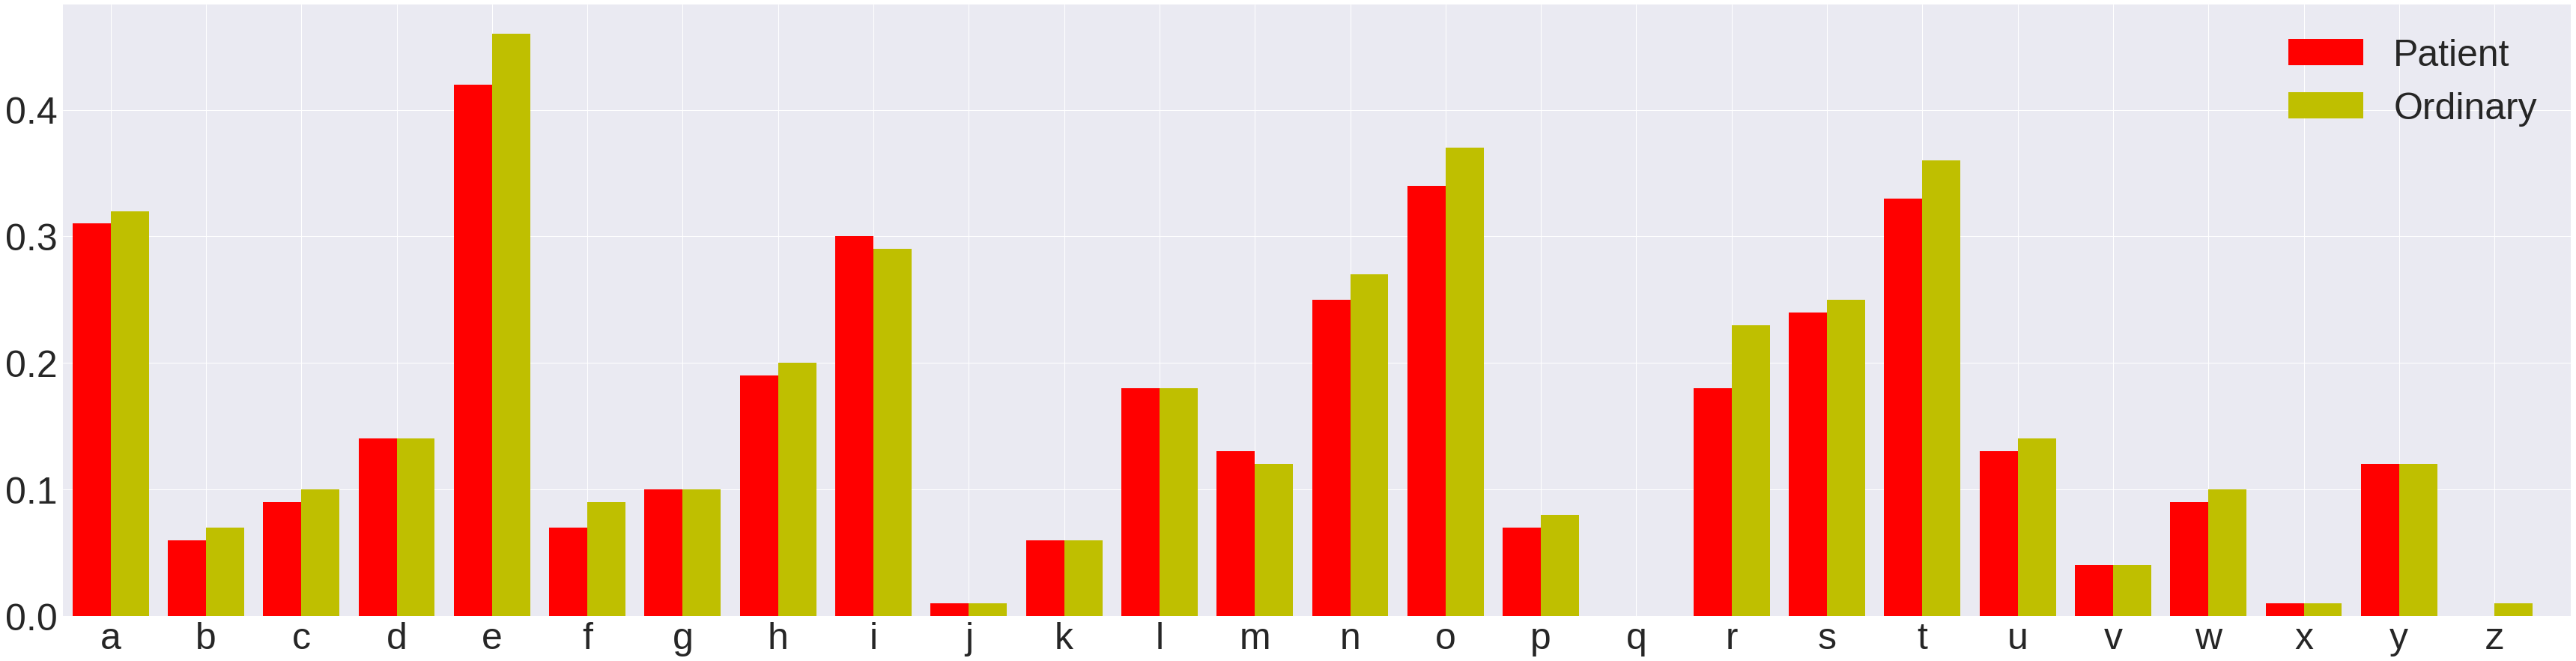

In [113]:
alphabetList = list(string.ascii_lowercase)
baseValues = []
groupValues = []

for alphabet in alphabetList:
    baseValues.append(round(baseAlphabetCounter[alphabet]/baseWordCounter, 2))
    groupValues.append(round(groupAlphabetCounter[alphabet]/groupWordCounter, 2))
      

plt.rcParams["figure.figsize"] = [60,15]
plt.rcParams["legend.fontsize"] = 50

ind = np.arange(len(alphabetList))  # the x locations for the groups
width = 0.4                         # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, groupValues, width, color='r')

rects2 = ax.bar(ind + width, baseValues, width, color='y')

ax.set_xticks(ind + width / 2)

ax.set_xticklabels(alphabetList)
ax.tick_params(axis='x', which='major', labelsize='50')
ax.tick_params(axis='y', which='major', labelsize='50')
ax.set_xlim(-0.3, 26)
ax.legend((rects1[0], rects2[0]), ('Patient', 'Ordinary'))

# plt.xticks(rotation='vertical')

#     # def autolabel(rects):
#     #     """
#     #     Attach a text label above each bar displaying its height
#     #     """
#     #     for rect in rects:
#     #         height = rect.get_height()
#     #         ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
#     #                 '%d' % int(height),
#     #                 ha='center', va='bottom')
#     # autolabel(rects1)
#     # autolabel(rects2)

plt.show()
plt.close(fig)

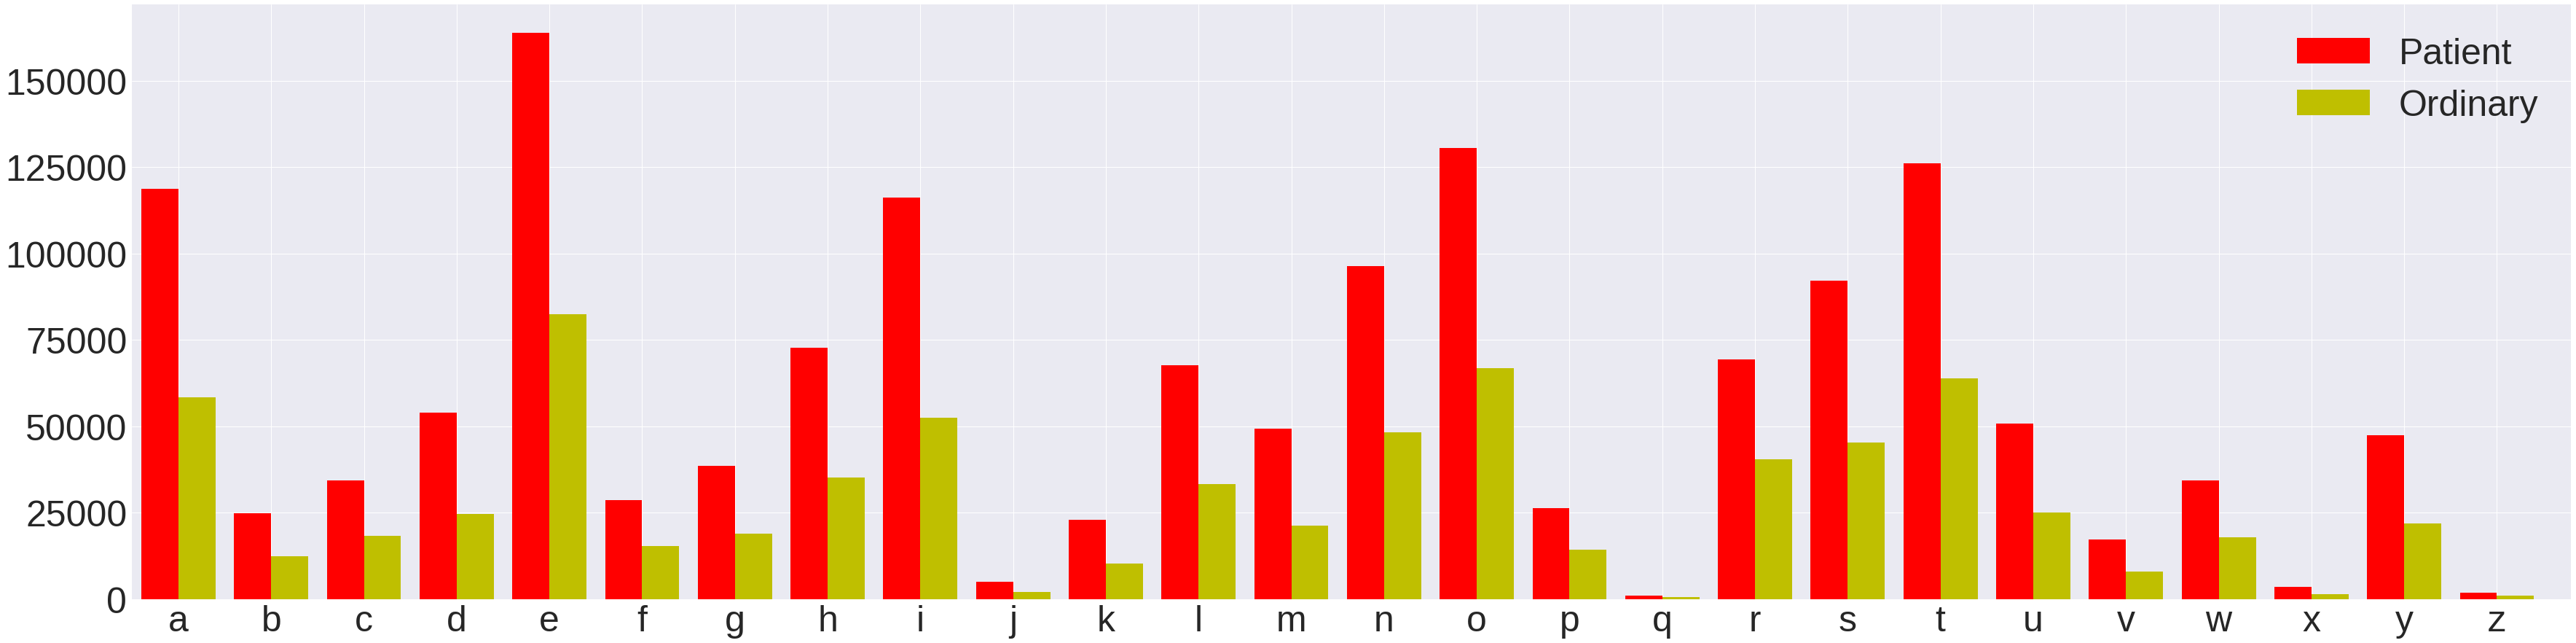

In [114]:
alphabetList = list(string.ascii_lowercase)
baseValues = []
groupValues = []

for alphabet in alphabetList:
    baseValues.append(baseAlphabetCounter[alphabet])
    groupValues.append(groupAlphabetCounter[alphabet])
      

plt.rcParams["figure.figsize"] = [60,15]
plt.rcParams["legend.fontsize"] = 50

ind = np.arange(len(alphabetList))  # the x locations for the groups
width = 0.4                         # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, groupValues, width, color='r')

rects2 = ax.bar(ind + width, baseValues, width, color='y')

ax.set_xticks(ind + width / 2)

ax.set_xticklabels(alphabetList)
ax.tick_params(axis='x', which='major', labelsize='50')
ax.tick_params(axis='y', which='major', labelsize='50')
ax.set_xlim(-0.3, 26)
ax.legend((rects1[0], rects2[0]), ('Patient', 'Ordinary'))

# plt.xticks(rotation='vertical')

#     # def autolabel(rects):
#     #     """
#     #     Attach a text label above each bar displaying its height
#     #     """
#     #     for rect in rects:
#     #         height = rect.get_height()
#     #         ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
#     #                 '%d' % int(height),
#     #                 ha='center', va='bottom')
#     # autolabel(rects1)
#     # autolabel(rects2)

plt.show()
plt.close(fig)